# Useful Functions & Dependecies:

In [1]:
#Dependecies
import numpy as np
from scipy.stats import kurtosis

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

In [613]:
#no linear transform on the data
def compute_statistics_old(samples):
    summary = []
    for sample in samples:
        mu = np.average(sample)
        var = np.var(sample)
        kurt = kurtosis(sample)
        
        quant = np.percentile(sample,[0,25,50,75,100])
        
        #total = np.append(quant,[mu,var,kurt])
        total = np.append(quant,[kurt])
        
        summary.append(total)
        
    return summary

#gathers relevant statistics -> packages into list of feature vectors
def compute_statistics(samples):
    summary = []
    for sample in samples:
        mu = np.average(sample)
        var = np.var(sample)
        kurt = kurtosis(sample)
        
        #testing this line
        sample = (sample-mu)/var
        quant = np.percentile(sample,[0,25,50,75,100])        
        total = np.append(quant,[kurt])
        
        summary.append(total)
        
    return summary

#Maps output argmax to name of distribution (used when testing edge cases)
def dist_map(dist_id):
    dist_mapping = {
        0:"Normal",
        1:"Exponential",
        2:"Poisson",
        3:"Uniform",
        4:"Beta",
        5:"Gamma"
    }
    return dist_mapping[dist_id]

# Sample Generation
- Generating 100 samples for each of the basic continuous distributions learned in an intro to probability course
- They will have random parameters
- Exponential, Normal, Beta, Gamma, Poisson, Uniform


In [3]:
# DIST ID's
# 0 -> normal
# 1 -> exponential
# 2 -> poisson
# 3 -> binomial
# 4 -> uniform
# 5 -> beta
# 6 -> gamma

#Choose number of samples to generate
def gen_samples(num_samples):
    
    #Generate samples for each distribution
    normalSamples = []
    for i in range(num_samples):
        mu = np.random.uniform(-10000,10000)
        sigma = np.random.uniform(1e-9,1000)
        normalSamples.append(np.random.normal(mu,sigma,100))

    expSamples = []
    for i in range(num_samples):
        lambd = np.random.uniform(1e-9,1000)
        expSamples.append(np.random.exponential(lambd,100))

    poissSamples = []
    for i in range(num_samples):
        lambd = np.random.uniform(1e-9,1000)
        poissSamples.append(np.random.poisson(lambd,100))
        
    uniformSamples = []
    for i in range(num_samples):
        a = np.random.uniform(-10000,10000)
        b = np.random.uniform(-10000,10000)
        uniformSamples.append(np.random.uniform(min(a,b),max(a,b),100))
        
    betaSamples = []
    for i in range(num_samples):
        #beta params
        a = np.random.uniform(0,10000)
        b = np.random.uniform(0,10000)
        betaSamples.append(np.random.beta(a,b,100))
        
    gammaSamples = []
    for i in range(num_samples):
        #gamma params
        shape = np.random.uniform(0,10000)
        scale = np.random.uniform(0,10000)
        gammaSamples.append(np.random.gamma(shape,scale,100))
        
    #create matrix of feature vectors, vector of labels
    normal_labels = np.zeros((num_samples,))
    normal_samples = np.vstack(compute_statistics(normalSamples))

    exp_labels = np.ones((num_samples,))
    exp_samples = np.vstack(compute_statistics(expSamples))

    poiss_labels = np.ones((num_samples,)) + 1
    poiss_samples = np.vstack(compute_statistics(poissSamples))
    
    uniform_labels = np.ones((num_samples,)) + 2
    uniform_samples = np.vstack(compute_statistics(uniformSamples))
    
    beta_labels = np.ones((num_samples,)) + 3
    beta_samples = np.vstack(compute_statistics(uniformSamples))
    
    gamma_labels = np.ones((num_samples,)) + 4
    gamma_samples = np.vstack(compute_statistics(gammaSamples))
    
    
    #create the training data
    x = np.vstack([normal_samples,exp_samples,poiss_samples,uniform_samples,beta_samples,gamma_samples])
    y = np.hstack([normal_labels,exp_labels,poiss_labels,uniform_labels,beta_labels,gamma_labels])

    # convert the labels to one-hot encoded vectors
    y = to_categorical(y, num_classes=6)
    
    return x, y

def gen_samples_old(num_samples):
    
    #Generate samples for each distribution
    normalSamples = []
    for i in range(num_samples):
        mu = np.random.uniform(-10000,10000)
        sigma = np.random.uniform(1e-9,1000)
        normalSamples.append(np.random.normal(mu,sigma,100))

    expSamples = []
    for i in range(num_samples):
        lambd = np.random.uniform(1e-9,1000)
        expSamples.append(np.random.exponential(lambd,100))

    poissSamples = []
    for i in range(num_samples):
        lambd = np.random.uniform(1e-9,1000)
        poissSamples.append(np.random.poisson(lambd,100))
        
    uniformSamples = []
    for i in range(num_samples):
        a = np.random.uniform(-10000,10000)
        b = np.random.uniform(-10000,10000)
        uniformSamples.append(np.random.uniform(min(a,b),max(a,b),100))
        
    betaSamples = []
    for i in range(num_samples):
        #beta params
        a = np.random.uniform(0,10000)
        b = np.random.uniform(0,10000)
        betaSamples.append(np.random.beta(a,b,100))
        
    gammaSamples = []
    for i in range(num_samples):
        #gamma params
        shape = np.random.uniform(0,10000)
        scale = np.random.uniform(0,10000)
        gammaSamples.append(np.random.gamma(shape,scale,100))
        
    #create matrix of feature vectors, vector of labels
    normal_labels = np.zeros((num_samples,))
    normal_samples = np.vstack(compute_statistics_old(normalSamples))

    exp_labels = np.ones((num_samples,))
    exp_samples = np.vstack(compute_statistics_old(expSamples))

    poiss_labels = np.ones((num_samples,)) + 1
    poiss_samples = np.vstack(compute_statistics_old(poissSamples))
    
    uniform_labels = np.ones((num_samples,)) + 2
    uniform_samples = np.vstack(compute_statistics_old(uniformSamples))
    
    beta_labels = np.ones((num_samples,)) + 3
    beta_samples = np.vstack(compute_statistics_old(uniformSamples))
    
    gamma_labels = np.ones((num_samples,)) + 4
    gamma_samples = np.vstack(compute_statistics_old(gammaSamples))
    
    
    #create the training data
    x = np.vstack([normal_samples,exp_samples,poiss_samples,uniform_samples,beta_samples,gamma_samples])
    y = np.hstack([normal_labels,exp_labels,poiss_labels,uniform_labels,beta_labels,gamma_labels])

    # convert the labels to one-hot encoded vectors
    y = to_categorical(y, num_classes=6)
    
    return x, y

# Testing own implementation of tensorflow

In [406]:
import neural_net as nn

import numpy as np
from scipy.stats import kurtosis
from tensorflow.keras.utils import to_categorical

In [707]:
import importlib
importlib.reload(nn)

relu = nn.ReLu()
softmax = nn.Softmax()

model = nn.Neural_Net([nn.FeatureLayer(6, relu),
                 #nn.DenseLayer(72, relu),
                 nn.DenseLayer(32, relu),
                 nn.OutputLayer(6, softmax)],
               nn.categorical_crossentropy,
               0.01)

In [708]:
#get training data, test data
num_samples = 100
x_train, y_train = gen_samples(num_samples)
x_test, y_test = gen_samples(num_samples)

acc_hist, loss_hist, avg_loss_hist, conf = model.train(x_train,y_train,x_train,y_train,20,10)

Initial Stats: accuracy: 0.0 avg_loss: 0.32
Epoch 1 : accuracy: 0.0017 avg_loss: 0.3048
Epoch 2 : accuracy: 0.0317 avg_loss: 0.2999
Epoch 3 : accuracy: 0.065 avg_loss: 0.2958
Epoch 4 : accuracy: 0.0683 avg_loss: 0.2962
Epoch 5 : accuracy: 0.0667 avg_loss: 0.2963
Epoch 6 : accuracy: 0.0783 avg_loss: 0.2948
Epoch 7 : accuracy: 0.08 avg_loss: 0.2948
Epoch 8 : accuracy: 0.0933 avg_loss: 0.2931
Epoch 9 : accuracy: 0.1067 avg_loss: 0.2917
Epoch 10 : accuracy: 0.1317 avg_loss: 0.2908
Epoch 11 : accuracy: 0.115 avg_loss: 0.2921
Epoch 12 : accuracy: 0.1183 avg_loss: 0.2939
Epoch 13 : accuracy: 0.1083 avg_loss: 0.295
Epoch 14 : accuracy: 0.1217 avg_loss: 0.2948
Epoch 15 : accuracy: 0.2117 avg_loss: 0.2927
Epoch 16 : accuracy: 0.2417 avg_loss: 0.2912
Epoch 17 : accuracy: 0.2733 avg_loss: 0.2916
Epoch 18 : accuracy: 0.2733 avg_loss: 0.2933
Epoch 19 : accuracy: 0.2733 avg_loss: 0.295
Epoch 20 : accuracy: 0.2767 avg_loss: 0.2954


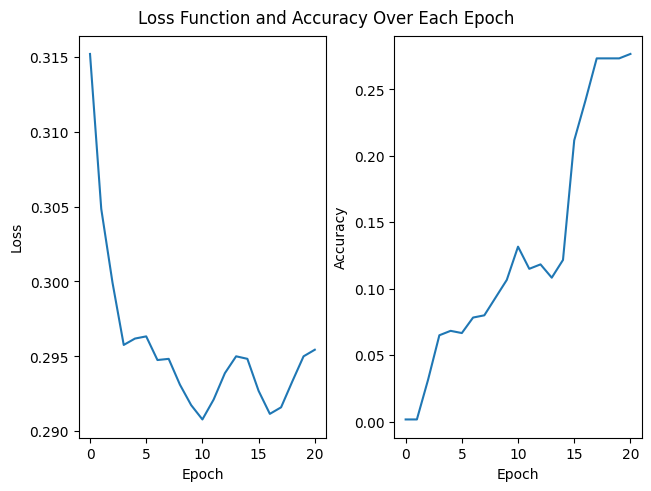

In [709]:
fig, (ax1, ax2) = plt.subplots(1, 2,constrained_layout = True)
fig.suptitle('Loss Function and Accuracy Over Each Epoch')
ax1.plot(avg_loss_hist)
ax1.set(xlabel='Epoch', ylabel='Loss')

ax2.plot(acc_hist)
ax2.set(xlabel='Epoch', ylabel='Accuracy')

print("")

In [710]:
print("Confusion Matrix: x=predicted, y=true")
conf

Confusion Matrix: x=predicted, y=true


array([[  0.,   0.,   0., 100.,   0.,   0.],
       [  0.,  66.,   0.,  34.,   0.,   0.],
       [  0.,   1.,   0.,  98.,   1.,   0.],
       [  0.,   0.,   0., 100.,   0.,   0.],
       [  0.,   0.,   0., 100.,   0.,   0.],
       [  0.,   0.,   0., 100.,   0.,   0.]])

# Tensorflow Models:

In [12]:
#get training data, test data (keep same for each model)
x_train, y_train = gen_samples(10000)
x_test, y_test = gen_samples(100)

x_train_old, y_train_old = gen_samples_old(10000)
x_test_old, y_test_old = gen_samples_old(100)

In [13]:
#initialize for confusion matrix
#cite this:
# https://www.kaggle.com/code/mdmashurshalehin/plotting-confusion-matrix-for-tensorflow-model

#convert back to 1d array so confusion matrix works
y_test_labels = np.argmax(y_test, axis=1)

class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

class_names = ["Normal","Exponential","Poisson","Uniform","Beta","Gamma"]

# Model 0 - ReLu, Adam -> no data transformation

In [35]:
# Define model and train -> input shape => how many statistics

#sequential model => one set of inputs, one set of outputs
model0 = Sequential()
model0.add(Dense(72, activation='relu', input_shape=(6,)))
model0.add(Dense(36, activation='relu'))
#softmax last layer -> give probability
model0.add(Dense(6, activation='softmax'))

#use adam since better than SGD
#categorical crossentropy loss
model0.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# train the model (shuffle=True on by default)
history0 = model0.fit(x_train_old, y_train_old, epochs=20, batch_size = 25,
                   validation_data = (x_test_old,y_test_old))

# evaluate the model on the training set
print("---------------------------------------------------------------------------------------------")
print("Model evaluation:")
test_loss, test_acc = model0.evaluate(x_test_old, y_test_old)

Epoch 1/20
2400/2400 [==============================] - 2s 711us/step - loss: 226.8405 - accuracy: 0.5375 - val_loss: 208.7200 - val_accuracy: 0.5550
Epoch 2/20
2400/2400 [==============================] - 1s 565us/step - loss: 180.3571 - accuracy: 0.5932 - val_loss: 103.0550 - val_accuracy: 0.6067
Epoch 3/20
2400/2400 [==============================] - 1s 569us/step - loss: 316.0517 - accuracy: 0.5838 - val_loss: 54.3695 - val_accuracy: 0.6133
Epoch 4/20
2400/2400 [==============================] - 1s 558us/step - loss: 160.6542 - accuracy: 0.6615 - val_loss: 131.6042 - val_accuracy: 0.5900
Epoch 5/20
2400/2400 [==============================] - 1s 553us/step - loss: 882.6810 - accuracy: 0.5829 - val_loss: 2551.5142 - val_accuracy: 0.5067
Epoch 6/20
2400/2400 [==============================] - 1s 554us/step - loss: 499.5193 - accuracy: 0.6257 - val_loss: 639.6130 - val_accuracy: 0.5400
Epoch 7/20
2400/2400 [==============================] - 1s 546us/step - loss: 649.7117 - accuracy: 0

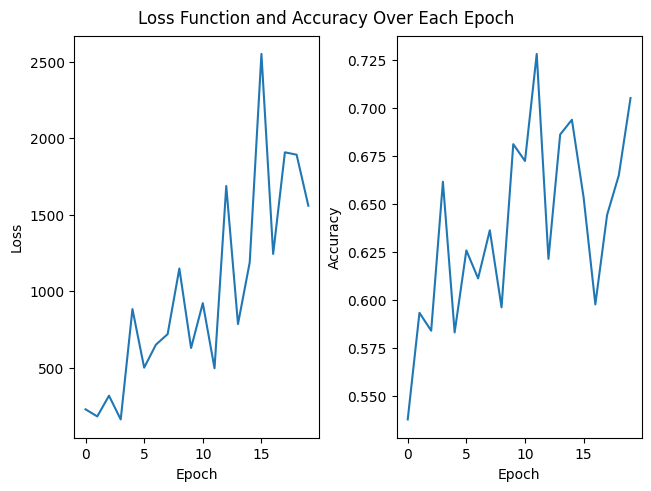

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2,constrained_layout = True)
fig.suptitle('Loss Function and Accuracy Over Each Epoch')
ax1.plot(history0.history['loss'])
ax1.set(xlabel='Epoch', ylabel='Loss')

ax2.plot(history0.history['accuracy'])
ax2.set(xlabel='Epoch', ylabel='Accuracy')

print("")

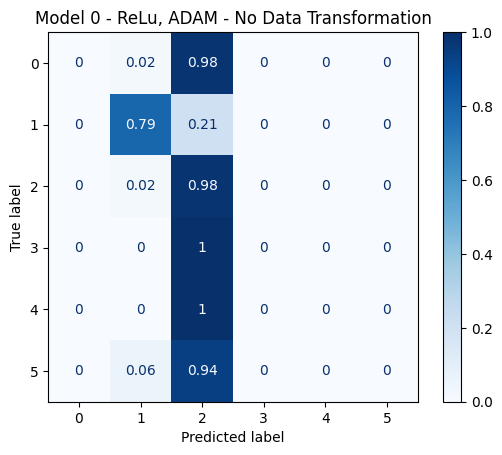

In [37]:
classifier0 = estimator(model0, class_names)

figsize = (12,12)
disp = plot_confusion_matrix(estimator=classifier0, X=x_test, y_true=y_test_labels, 
                      cmap='Blues',normalize='true')
disp.ax_.set_title("Model 0 - ReLu, ADAM - No Data Transformation")
print("")

# Model 1 - ReLu, Adam

In [19]:
# Define model and train -> input shape => how many statistics

#sequential model => one set of inputs, one set of outputs
model1 = Sequential()
model1.add(Dense(72, activation='relu', input_shape=(6,)))
model1.add(Dense(36, activation='relu'))
#softmax last layer -> give probability
model1.add(Dense(6, activation='softmax'))

#use adam since better than SGD
#categorical crossentropy loss
model1.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# train the model (shuffle=True on by default)
history1 = model1.fit(x_train, y_train, epochs=20, batch_size = 25,
                   validation_data = (x_test,y_test))

# evaluate the model on the training set
print("---------------------------------------------------------------------------------------------")
print("Model evaluation:")
test_loss, test_acc = model1.evaluate(x_test, y_test)

Epoch 1/20
2400/2400 [==============================] - 2s 610us/step - loss: 0.6629 - accuracy: 0.6783 - val_loss: 0.5487 - val_accuracy: 0.7733
Epoch 2/20
2400/2400 [==============================] - 1s 583us/step - loss: 0.4719 - accuracy: 0.7650 - val_loss: 0.4254 - val_accuracy: 0.7867
Epoch 3/20
2400/2400 [==============================] - 1s 577us/step - loss: 0.3775 - accuracy: 0.7967 - val_loss: 0.3725 - val_accuracy: 0.7967
Epoch 4/20
2400/2400 [==============================] - 1s 566us/step - loss: 0.3450 - accuracy: 0.7988 - val_loss: 0.3357 - val_accuracy: 0.8000
Epoch 5/20
2400/2400 [==============================] - 1s 563us/step - loss: 0.3356 - accuracy: 0.8029 - val_loss: 0.3362 - val_accuracy: 0.7983
Epoch 6/20
2400/2400 [==============================] - 1s 582us/step - loss: 0.3310 - accuracy: 0.8025 - val_loss: 0.3171 - val_accuracy: 0.8083
Epoch 7/20
2400/2400 [==============================] - 1s 572us/step - loss: 0.3235 - accuracy: 0.8042 - val_loss: 0.3136 -

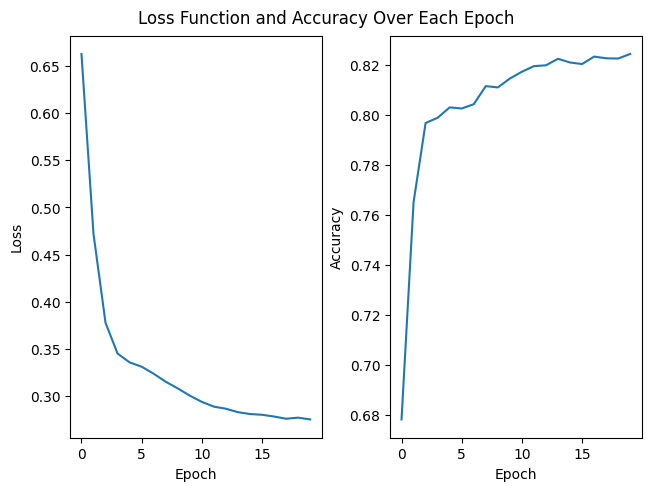

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2,constrained_layout = True)
fig.suptitle('Loss Function and Accuracy Over Each Epoch')
ax1.plot(history1.history['loss'])
ax1.set(xlabel='Epoch', ylabel='Loss')

ax2.plot(history1.history['accuracy'])
ax2.set(xlabel='Epoch', ylabel='Accuracy')

print("")

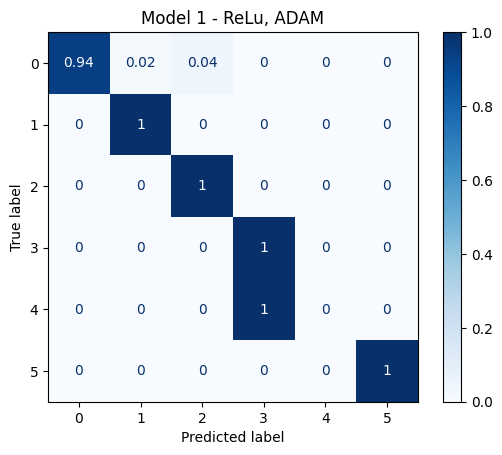

In [23]:
classifier1 = estimator(model1, class_names)

figsize = (12,12)
disp = plot_confusion_matrix(estimator=classifier1, X=x_test, y_true=y_test_labels, 
                      cmap='Blues',normalize='true')
disp.ax_.set_title("Model 1 - ReLu, ADAM")
print("")

## Testing model on real world data - population of heights

In [744]:
import pandas as pd

full = pd.read_csv('./data/SOCR-HeightWeight.csv')

height = np.array([full['Height(Inches)']])
height_t = compute_statistics(height)

pred_height = dist_map(np.argmax(model1.predict(np.array([height_t]))))

print("Prediction:",pred_height)

Prediction: Normal


# Model 2 - Sigmoid, Adam

In [26]:
# Define model and train -> input shape => how many statistics

#sequential model => one set of inputs, one set of outputs
model2 = Sequential()
model2.add(Dense(72, activation='sigmoid', input_shape=(6,)))
model2.add(Dense(36, activation='sigmoid'))
#softmax last layer -> give probability
model2.add(Dense(6, activation='softmax'))

#use adam since better than SGD
#categorical crossentropy loss
model2.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# train the model (shuffle=True on by default)
history2 = model2.fit(x_train, y_train, epochs=20, batch_size = 25,
                   validation_data = (x_test,y_test))

# evaluate the model on the training set
print("---------------------------------------------------------------------------------------------")
print("Model evaluation:")
test_loss2, test_acc2 = model2.evaluate(x_test, y_test)

Epoch 1/20
2400/2400 [==============================] - 2s 604us/step - loss: 0.9631 - accuracy: 0.5752 - val_loss: 0.6549 - val_accuracy: 0.6983
Epoch 2/20
2400/2400 [==============================] - 1s 574us/step - loss: 0.5932 - accuracy: 0.6930 - val_loss: 0.5943 - val_accuracy: 0.7000
Epoch 3/20
2400/2400 [==============================] - 1s 568us/step - loss: 0.5449 - accuracy: 0.7317 - val_loss: 0.5473 - val_accuracy: 0.7800
Epoch 4/20
2400/2400 [==============================] - 1s 554us/step - loss: 0.5013 - accuracy: 0.7551 - val_loss: 0.4993 - val_accuracy: 0.7633
Epoch 5/20
2400/2400 [==============================] - 1s 561us/step - loss: 0.4559 - accuracy: 0.7759 - val_loss: 0.4506 - val_accuracy: 0.7800
Epoch 6/20
2400/2400 [==============================] - 1s 548us/step - loss: 0.4120 - accuracy: 0.7885 - val_loss: 0.4048 - val_accuracy: 0.7833
Epoch 7/20
2400/2400 [==============================] - 1s 549us/step - loss: 0.3789 - accuracy: 0.7954 - val_loss: 0.3737 -

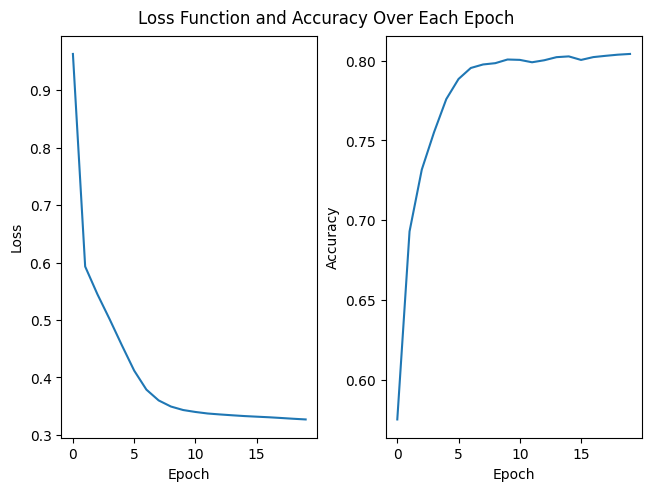

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2,constrained_layout = True)
fig.suptitle('Loss Function and Accuracy Over Each Epoch')
ax1.plot(history2.history['loss'])
ax1.set(xlabel='Epoch', ylabel='Loss')
ax2.plot(history2.history['accuracy'])
ax2.set(xlabel='Epoch', ylabel='Accuracy')
print("")

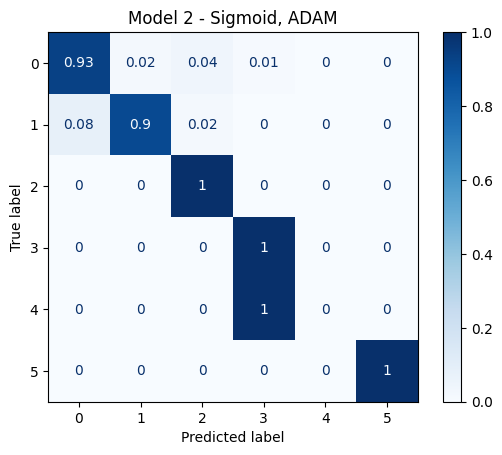

In [33]:
classifier2 = estimator(model2, class_names)

figsize = (12,12)
disp2 = plot_confusion_matrix(estimator=classifier2, X=x_test, y_true=y_test_labels, 
                      cmap='Blues',normalize='true')
disp2.ax_.set_title("Model 2 - Sigmoid, ADAM")
print("")

# Model 3 - ReLu, SGD

In [38]:
# Define model and train -> input shape => how many statistics

#sequential model => one set of inputs, one set of outputs
model3 = Sequential()
model3.add(Dense(72, activation='relu', input_shape=(6,)))
model3.add(Dense(36, activation='relu'))
#softmax last layer -> give probability
model3.add(Dense(6, activation='softmax'))

#use adam since better than SGD
#categorical crossentropy loss
model3.compile(optimizer='sgd', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# train the model (shuffle=True on by default)
history3 = model3.fit(x_train, y_train, epochs=20, batch_size = 25,
                   validation_data = (x_test,y_test))

# evaluate the model on the training set
print("---------------------------------------------------------------------------------------------")
print("Model evaluation:")
test_loss, test_acc = model3.evaluate(x_test, y_test)

Epoch 1/20
2400/2400 [==============================] - 1s 505us/step - loss: 1.0863 - accuracy: 0.5483 - val_loss: 0.8805 - val_accuracy: 0.6150
Epoch 2/20
2400/2400 [==============================] - 1s 473us/step - loss: 0.7978 - accuracy: 0.6385 - val_loss: 0.7474 - val_accuracy: 0.6417
Epoch 3/20
2400/2400 [==============================] - 1s 479us/step - loss: 0.6908 - accuracy: 0.6694 - val_loss: 0.6750 - val_accuracy: 0.6983
Epoch 4/20
2400/2400 [==============================] - 1s 470us/step - loss: 0.6294 - accuracy: 0.6860 - val_loss: 0.6291 - val_accuracy: 0.7383
Epoch 5/20
2400/2400 [==============================] - 1s 471us/step - loss: 0.5924 - accuracy: 0.7022 - val_loss: 0.6049 - val_accuracy: 0.6600
Epoch 6/20
2400/2400 [==============================] - 1s 476us/step - loss: 0.5729 - accuracy: 0.7066 - val_loss: 0.5855 - val_accuracy: 0.6733
Epoch 7/20
2400/2400 [==============================] - 1s 460us/step - loss: 0.5599 - accuracy: 0.7171 - val_loss: 0.5778 -

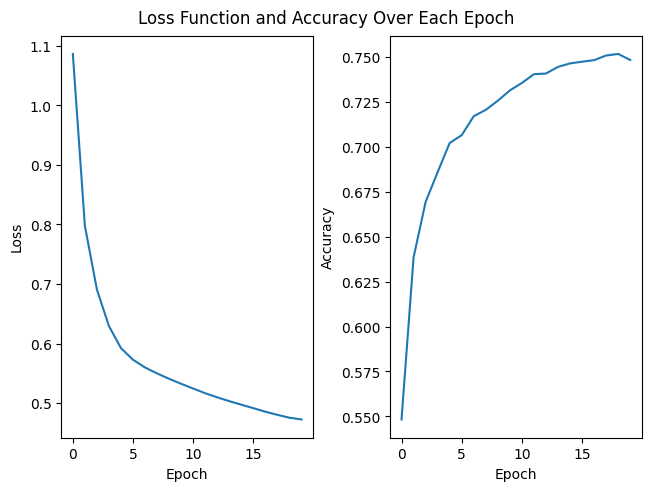

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2,constrained_layout = True)
fig.suptitle('Loss Function and Accuracy Over Each Epoch')
ax1.plot(history3.history['loss'])
ax1.set(xlabel='Epoch', ylabel='Loss')
ax2.plot(history3.history['accuracy'])
ax2.set(xlabel='Epoch', ylabel='Accuracy')
print("")

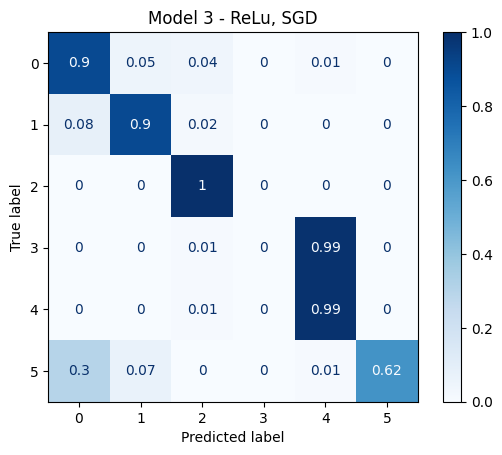

In [40]:
classifier3 = estimator(model3, class_names)

figsize = (12,12)
disp3 = plot_confusion_matrix(estimator=classifier3, X=x_test, y_true=y_test_labels, 
                      cmap='Blues',normalize='true')
disp3.ax_.set_title("Model 3 - ReLu, SGD")
print("")

# Model 4 - Sigmoid, SGD

In [42]:
# Define model and train -> input shape => how many statistics

#sequential model => one set of inputs, one set of outputs
model4 = Sequential()
model4.add(Dense(72, activation='sigmoid', input_shape=(6,)))
model4.add(Dense(36, activation='sigmoid'))
#softmax last layer -> give probability
model4.add(Dense(6, activation='softmax'))

#use adam since better than SGD
#categorical crossentropy loss
model4.compile(optimizer='sgd', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# train the model (shuffle=True on by default)
history4 = model4.fit(x_train, y_train, epochs=20, batch_size = 25,
                   validation_data = (x_test,y_test))

# evaluate the model on the training set
print("---------------------------------------------------------------------------------------------")
print("Model evaluation:")
test_loss, test_acc = model4.evaluate(x_test, y_test)

Epoch 1/20
2400/2400 [==============================] - 1s 516us/step - loss: 1.6216 - accuracy: 0.3810 - val_loss: 1.4445 - val_accuracy: 0.4400
Epoch 2/20
2400/2400 [==============================] - 1s 476us/step - loss: 1.2795 - accuracy: 0.4614 - val_loss: 1.1687 - val_accuracy: 0.4500
Epoch 3/20
2400/2400 [==============================] - 1s 474us/step - loss: 1.0753 - accuracy: 0.4800 - val_loss: 1.0332 - val_accuracy: 0.4650
Epoch 4/20
2400/2400 [==============================] - 1s 499us/step - loss: 0.9887 - accuracy: 0.4917 - val_loss: 0.9792 - val_accuracy: 0.5833
Epoch 5/20
2400/2400 [==============================] - 1s 498us/step - loss: 0.9508 - accuracy: 0.4969 - val_loss: 0.9508 - val_accuracy: 0.4833
Epoch 6/20
2400/2400 [==============================] - 1s 492us/step - loss: 0.9306 - accuracy: 0.5000 - val_loss: 0.9357 - val_accuracy: 0.5100
Epoch 7/20
2400/2400 [==============================] - 1s 486us/step - loss: 0.9177 - accuracy: 0.5090 - val_loss: 0.9245 -

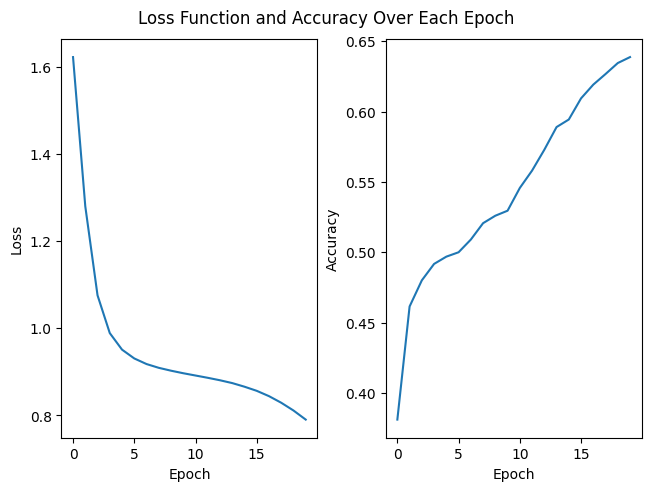

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2,constrained_layout = True)
fig.suptitle('Loss Function and Accuracy Over Each Epoch')
ax1.plot(history4.history['loss'])
ax1.set(xlabel='Epoch', ylabel='Loss')
ax2.plot(history4.history['accuracy'])
ax2.set(xlabel='Epoch', ylabel='Accuracy')
print("")

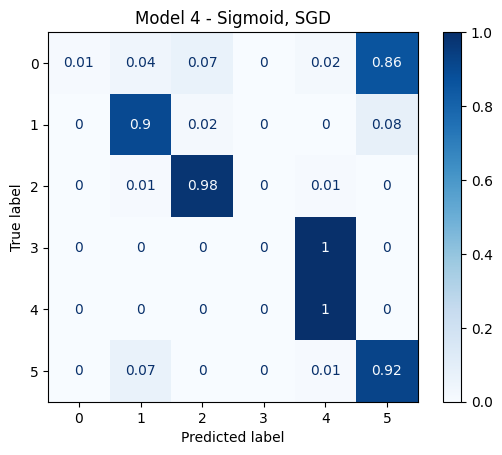

In [45]:
classifier4 = estimator(model4, class_names)

figsize = (12,12)
disp3 = plot_confusion_matrix(estimator=classifier4, X=x_test, y_true=y_test_labels, 
                      cmap='Blues',normalize='true')
disp3.ax_.set_title("Model 4 - Sigmoid, SGD")
print("")